# Project Title:
## Using PySpark for Image Classification on Satellite Imagery of Agricultural Terrains 

**Course :** CS696 - Big Data Tools and Methods 

**Team Members:** 
- Shah, Saumil : 82319571
- Naidu, Indraraj : 823383841
---

### Description
This is notebook intended to be used with ```project_deepsat_aws.py```, since it relies on the model trained and predictions done on AWS using the latter to be visulaized in this notebook towards end of the sections

### Outline

[1. Imports](#1.-Imports)
- [1.1 Helper Functions](#1.1-Helper-Functions)

[2. Define Base Directory and Sub File Paths](#2.-Define-Base-Directory-and-Sub-File-Paths)

[3. Read Data](#3.-Read-Data)
- [3.1 Training Data](#3.1-Training-Data)
- [3.2 Testing Data](#3.2-Testing-Data)

[4. Data Transformation Pipeline Stages](#4.-Data-Transformation-Pipeline-Stages)
- [4.1 Transformation Stages](#4.1-Transformation-Stages)
    - [4.1.1 Stages of X (data)](#4.1.1-Stages-of-X-(data))
    - [4.1.2 Stages of y (labels)](#4.1.2-Stages-of-y-(labels))
- [4.2 Feature Extraction](#4.2-Feature-Extraction)
    - [4.2.1 Vector Assembly and Scaling](#4.2.1-Vector-Assembly-and-Scaling)
    - [4.2.2 PCA](#4.2.2-PCA)

[5. Classification and Prediction](#5.-Classification-and-Prediction)
- [5.1 Random Forest Model](#5.1-Random-Forest-Model)
    - [5.1.1 Training Model](#5.1.1-Training-Model)
    - [5.1.2 Predict using Model - Locally](#5.1.2-Predict-using-Model---Locally)
    - [5.1.3 Evaluation on Model Trained - Locally](#5.1.3-Evaluation-on-Model-Trained---Locally)

[6. Predict using Model from AWS](#6.-Predict-using-Model-from-AWS)
- [6.1 Load Random Forest Model Trained on AWS](#6.1-Load-Random-Forest-Model-Trained-on-AWS)
- [6.2 Evaluation Calculated done over X_test on AWS](#6.2-Evaluation-Calculated-done-over-X_test-on-AWS)

[7. Use AWS Model to predict on Local Data](#7.-Use-AWS-Model-to-predict-on-Local-Data)
- [7.1 Predict using Model Trained on AWS over Local Test Data](#7.1-Predict-using-Model-Trained-on-AWS-over-Local-Test-Data)
- [7.2 Evaluation of Model trained on AWS over Custom Local Data](#7.2-Evaluation-of-Model-trained-on-AWS-over-Custom-Local-Data)

[8. AWS CLI Export](#8.-AWS-CLI-Export)

---

## 1. Imports

In [1]:
import os
import argparse
import random
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import chain
from matplotlib import pyplot as plt

In [2]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as fn 

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, PCAModel
from pyspark.ml.feature import PCA as PCA_Spark
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassificationModel

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.util import MLUtils

In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
spark = SparkSession \
    .builder \
    .appName("CS696-Project-DeepSAT") \
    .getOrCreate()

In [5]:
spark

In [6]:
reader = spark.read
reader.option("header", "false")
reader.option("inferSchema", "true")

In [7]:
def spark_shape(self):
    return (self.count(), len(self.columns))
pyspark.sql.dataframe.DataFrame.shape = spark_shape

### 1.1 Helper Functions

#### Demo Mode

- If you want to run this file locally set the ```demo_mode``` to ```True``` since it will only load ```demo_rows_n``` number of rows from any of the ```large_set``` or the ```small_set```.


- For more details on ```large_set``` and ```small_set``` go to ***Section 2. Define Base Directory and Sub File Paths***.

In [8]:
demo_mode = False
demo_rows_n = 10

In [9]:
def join_X_and_y(X, y):
    
    X_new = X.withColumn("col_index", fn.monotonically_increasing_id().alias("rowId"))
    y_new = y.withColumn("col_index", fn.monotonically_increasing_id().alias("rowId"))
    
    joined_X_y = X_new.join(y_new, "col_index", 'inner').drop("col_index")
    print(joined_X_y.shape())
    return joined_X_y

In [10]:
# Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

---

### 2. Define Base Directory and Sub File Paths

#### Note:
- If you want to run this file locally use the ```small_set``` since it will only load 200 rows from the large dataset instead of loading thousands of rows.

- If you wish run this code on entire dataset (Training Data ~400k rows, Testing Data ~100k rows) then only use ```large_set``` and comment ```small_set``` paths.

In [11]:
base_dir = './deepsat-sat6'
path_ann = 'sat6annotations.csv'

# large_set
path_train_X, path_train_y, path_test_X, path_test_y = \
['X_train_sat6.csv', 'y_train_sat6.csv', 'X_test_sat6.csv', 'y_test_sat6.csv']

# small_set
path_train_X, path_train_y, path_test_X, path_test_y = \
['train_X_200.csv', 'train_y_200.csv', 'test_X_200.csv', 'test_y_200.csv']

In [12]:
ann_data_path = os.path.join(base_dir, path_ann)

X_train_data_path = os.path.join(base_dir, path_train_X)
y_train_path = os.path.join(base_dir, path_train_y)

X_test_data_path = os.path.join(base_dir, path_test_X)
y_test_path = os.path.join(base_dir, path_test_y)

print(os.listdir(base_dir))

['random_forest.model', '.DS_Store', 'Icon\r', 'pca_5.model', 'train_y_200.csv', 'train_X_200.csv', 'test_y_200.csv', 'test_X_200.csv', 'sat6annotations.csv', 'predictionAndLabels.csv']


In [13]:
ann_spark = reader.csv(ann_data_path, sep=',', header=False)
ann_spark = ann_spark.orderBy(fn.asc("_c1"), fn.asc("_c2"), fn.asc("_c3"), fn.asc("_c4"), fn.asc("_c5"), fn.asc("_c6"))
ann_spark.show()

+-----------+---+---+---+---+---+---+
|        _c0|_c1|_c2|_c3|_c4|_c5|_c6|
+-----------+---+---+---+---+---+---+
|      water|  0|  0|  0|  0|  0|  1|
|       road|  0|  0|  0|  0|  1|  0|
|  grassland|  0|  0|  0|  1|  0|  0|
|      trees|  0|  0|  1|  0|  0|  0|
|barren_land|  0|  1|  0|  0|  0|  0|
|   building|  1|  0|  0|  0|  0|  0|
+-----------+---+---+---+---+---+---+



In [14]:
category_names = np.array([c['_c0'] for c in ann_spark.select('_c0').collect()])
category_names

array(['water', 'road', 'grassland', 'trees', 'barren_land', 'building'],
      dtype='<U11')

#### Pandas

In [15]:
ann_data = pd.read_csv(ann_data_path, header=None)
ann_data = ann_data.sort_values([1, 2, 3, 4, 5, 6]).reset_index(drop=True)
ann_data.head(10)

,0,1,2,3,4,5,6
0,water,0,0,0,0,0,1
1,road,0,0,0,0,1,0
2,grassland,0,0,0,1,0,0
3,trees,0,0,1,0,0,0
4,barren_land,0,1,0,0,0,0
5,building,1,0,0,0,0,0


In [16]:
category_names = ann_data[0].values
category_names

array(['water', 'road', 'grassland', 'trees', 'barren_land', 'building'],
      dtype=object)

#### Mapping of One-hot Labels to Categories

In [17]:
total_categories = len(category_names)
one_hot_labels_dict = { '0'*(total_categories-i-1)+'1'+'0'*(i): float(i+1)  for i in range(total_categories) }

mapping_expr = fn.create_map([fn.lit(x) for x in chain(*one_hot_labels_dict.items())])
print(one_hot_labels_dict)

{'000001': 1.0, '000010': 2.0, '000100': 3.0, '001000': 4.0, '010000': 5.0, '100000': 6.0}


## 3. Read Data

#### 3.1 Training Data

In [18]:
if demo_mode:
    X_train_spark = reader.csv(X_train_data_path, sep=',').limit(demo_rows_n)
else:
    X_train_spark = reader.csv(X_train_data_path, sep=',')
X_train_spark.shape()

(200, 3136)

In [19]:
if demo_mode:
    y_train = reader.csv(y_train_path, sep=',').limit(demo_rows_n)
else:
    y_train = reader.csv(y_train_path, sep=',')
y_train.shape()

(200, 6)

#### 3.2 Testing Data

In [20]:
if demo_mode:
    X_test_spark = reader.csv(X_test_data_path, sep=',').limit(demo_rows_n)
else:
    X_test_spark = reader.csv(X_test_data_path, sep=',')
X_test_spark.shape()

(200, 3136)

In [21]:
if demo_mode:
    y_test = reader.csv(y_test_path, sep=',').limit(demo_rows_n)
else:
    y_test = reader.csv(y_test_path, sep=',')
y_test.shape()

(200, 6)

#### Misc Attributes

In [22]:
img_dim = 28
channels = 3
n_features = img_dim**2 * channels

first_k_principal_components = 5
num_forest_trees = 3
category_cols = [fn.col('_c'+str(x)) for x in range(6)]

## 4. Data Transformation Pipeline Stages

### 4.1 Transformation Stages

#### 4.1.1 Stages of X (data)

In [23]:
vec_assembler = VectorAssembler(inputCols=['_c'+str(x) for x in range(n_features)], outputCol="features")
standard_scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [24]:
pca_spark = PCA_Spark(k=first_k_principal_components, inputCol="scaledFeatures", outputCol="features")
forest_classifier = RandomForestClassifier(numTrees = num_forest_trees)

In [25]:
X_pipeline = Pipeline(stages=[vec_assembler, standard_scaler])

#### 4.1.2 Stages of y (labels)

In [26]:
def transform_y(y_dataframe, category_cols_ids, mapping_expr):
    y_category = y_dataframe.select(fn.concat(*tuple(category_cols_ids)).alias('label'))
    y_category = y_category.withColumn('label', mapping_expr[y_category['label']])
    
    return y_category

### 4.2 Feature Extraction

#### 4.2.1 Vector Assembly and Scaling

In [27]:
X_train = X_pipeline.fit(X_train_spark).transform(X_train_spark).select("scaledFeatures")
X_train.shape()

(200, 1)

In [28]:
y_train_category = transform_y(y_train, category_cols, mapping_expr)
y_train_category.shape()

(200, 1)

In [29]:
X_test = X_pipeline.fit(X_test_spark).transform(X_test_spark).select("scaledFeatures")
X_test.shape()

(200, 1)

In [30]:
y_test_category = transform_y(y_test, category_cols, mapping_expr)
y_test_category.shape()

(200, 1)

#### 4.2.2 PCA

In [31]:
pca_model = pca_spark.fit(X_train)

In [32]:
"{:.2f}% Variance Captured by {} components out of {} features.".format(100*sum(pca_model.explainedVariance),
                                                                                first_k_principal_components,
                                                                                n_features)

'85.66% Variance Captured by 5 components out of 2352 features.'

In [33]:
pca_model_save_path = os.path.join(base_dir, "pca_{}.model".format(first_k_principal_components))
pca_model_save_path

'./deepsat-sat6/pca_5.model'

In [34]:
pca_model.write().overwrite().save(pca_model_save_path)
'PCA Model Saved at {}'.format(pca_model_save_path)

'PCA Model Saved at ./deepsat-sat6/pca_5.model'

In [35]:
X_train_reduced = pca_model.transform(X_train).select("features")

In [36]:
X_y_train = join_X_and_y(X_train_reduced, y_train_category)
X_y_train.show(10)

(200, 2)
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-79.694400361606...|  4.0|
|[-150.54741388769...|  5.0|
|[-64.293278377080...|  1.0|
|[-66.118869514306...|  1.0|
|[-117.26418097848...|  1.0|
|[-221.10453100913...|  6.0|
|[-158.01737613450...|  6.0|
|[-53.030709350684...|  1.0|
|[-126.43348259450...|  5.0|
|[-91.449595198327...|  4.0|
+--------------------+-----+
only showing top 10 rows



In [37]:
X_test_reduced = pca_model.transform(X_test).select("features")

In [38]:
X_y_test = join_X_and_y(X_test_reduced, y_test_category)
X_y_test.show(10)

(200, 2)
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-87.662274284632...|  4.0|
|[-103.03198483140...|  4.0|
|[-94.520959152479...|  1.0|
|[-139.40152331099...|  5.0|
|[-47.345336605289...|  1.0|
|[-92.230247133919...|  4.0|
|[-50.491307094955...|  1.0|
|[-154.47313746296...|  5.0|
|[-62.604195239964...|  1.0|
|[-67.422376073001...|  1.0|
+--------------------+-----+
only showing top 10 rows



## 5. Classification and Prediction

### 5.1 Random Forest Model

#### 5.1.1 Training Model

In [39]:
random_forest_model = forest_classifier.fit(X_y_train)
random_forest_model.trees

[DecisionTreeClassificationModel (uid=dtc_0ec6f0f593c7) of depth 5 with 25 nodes,
 DecisionTreeClassificationModel (uid=dtc_c9ceb24c26cf) of depth 5 with 23 nodes,
 DecisionTreeClassificationModel (uid=dtc_0632d5dd2080) of depth 5 with 25 nodes]

In [40]:
model_save_path = os.path.join(base_dir, 'random_forest.model')
'Model Trained.'

'Model Trained.'

In [41]:
random_forest_model.write().overwrite().save(model_save_path)

In [42]:
'Model Saved at {}'.format(model_save_path)

'Model Saved at ./deepsat-sat6/random_forest.model'

#### 5.1.2 Predict using Model - Locally

In [43]:
load_forest = RandomForestClassificationModel.load(model_save_path)

In [44]:
model_pred = load_forest.transform(X_y_test)
model_pred.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-87.662274284632...|  4.0|[0.0,0.0,0.0,0.22...|[0.0,0.0,0.0,0.07...|       4.0|
|[-103.03198483140...|  4.0|[0.0,0.0,0.0,2.02...|[0.0,0.0,0.0,0.67...|       3.0|
|[-94.520959152479...|  1.0|[0.0,3.0,0.0,0.0,...|[0.0,1.0,0.0,0.0,...|       1.0|
|[-139.40152331099...|  5.0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|       5.0|
|[-47.345336605289...|  1.0|[0.0,3.0,0.0,0.0,...|[0.0,1.0,0.0,0.0,...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [45]:
predictionAndLabels = model_pred.select(['prediction', 'label']) \
                        .rdd.map(lambda line: (line[0], line[1]))

In [46]:
pred_labels_path = os.path.join(base_dir, 'predictionAndLabels.csv')
'Predictions made on Test Data.'

'Predictions made on Test Data.'

In [47]:
predictionAndLabels.toDF().coalesce(1).write.csv(pred_labels_path, sep=',', header='true', mode='overwrite')

In [48]:
'predictionAndLabels Saved at {}'.format(pred_labels_path)

'predictionAndLabels Saved at ./deepsat-sat6/predictionAndLabels.csv'

#### 5.1.3 Evaluation on Model Trained - Locally

In [49]:
pred_labels_saved_path = pred_labels_path
predictionAndLabels_from_file = reader.csv(pred_labels_saved_path, sep=',', header=True)

In [50]:
metrics = MulticlassMetrics(predictionAndLabels_from_file.rdd)

In [51]:
metrics.precision()

0.83

In [52]:
metrics.confusionMatrix().toArray()

array([[65.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., 16.,  3.,  8.,  0.],
       [ 0.,  0., 11., 35.,  0.,  0.],
       [ 4.,  0.,  3.,  0., 43.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  7.]])

#### Overall statistics

In [53]:
# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# Statistics by class
labels = model_pred.rdd.map(lambda lp: lp.label).distinct().collect()
for label in sorted(labels):
    print("\n\tClass %d precision = %s" % (label, metrics.precision(label)))
    print("\tClass %d recall = %s" % (label, metrics.recall(label)))
    print("\tClass %d F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))

# Weighted stats
print("\nWeighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Summary Stats
Precision = 0.83
Recall = 0.83
F1 Score = 0.83

	Class 1 precision = 0.8904109589041096
	Class 1 recall = 1.0
	Class 1 F1 Measure = 0.9420289855072463

	Class 2 precision = 0.0
	Class 2 recall = 0.0
	Class 2 F1 Measure = 0.0

	Class 3 precision = 0.5333333333333333
	Class 3 recall = 0.5925925925925926
	Class 3 F1 Measure = 0.5614035087719299

	Class 4 precision = 0.9210526315789473
	Class 4 recall = 0.7608695652173914
	Class 4 F1 Measure = 0.8333333333333333

	Class 5 precision = 0.8431372549019608
	Class 5 recall = 0.86
	Class 5 F1 Measure = 0.8514851485148515

	Class 6 precision = 0.875
	Class 6 recall = 0.875
	Class 6 F1 Measure = 0.875

Weighted recall = 0.8300000000000001
Weighted precision = 0.8190099806324838
Weighted F(1) Score = 0.8214868477694451
Weighted F(0.5) Score = 0.8192347366052124
Weighted false positive rate = 0.04820630089777489


In [54]:
model_pred_pd = model_pred.select('label', 'prediction').toPandas()
model_pred_pd.head()

,label,prediction
0,4.0,4.0
1,4.0,3.0
2,1.0,1.0
3,5.0,5.0
4,1.0,1.0


In [55]:
# model_pred_pd['label'].values
model_pred_pd['prediction'].values

array([4., 3., 1., 5., 1., 4., 1., 5., 1., 1., 1., 3., 3., 1., 4., 3., 5.,
       1., 6., 1., 3., 5., 5., 1., 5., 6., 1., 5., 3., 5., 1., 1., 1., 1.,
       6., 5., 1., 3., 5., 4., 4., 1., 3., 5., 3., 1., 6., 4., 1., 5., 4.,
       5., 4., 3., 4., 4., 4., 3., 1., 1., 5., 1., 3., 1., 1., 4., 5., 5.,
       1., 1., 4., 5., 1., 1., 5., 3., 1., 1., 4., 1., 1., 4., 1., 5., 3.,
       3., 4., 1., 4., 4., 4., 5., 5., 4., 4., 4., 5., 5., 1., 3., 1., 1.,
       6., 1., 5., 3., 6., 5., 1., 5., 1., 5., 5., 1., 5., 5., 1., 5., 5.,
       3., 5., 1., 4., 5., 1., 1., 4., 5., 3., 1., 4., 3., 1., 3., 3., 5.,
       4., 1., 1., 3., 3., 5., 5., 4., 1., 4., 3., 4., 4., 5., 5., 1., 1.,
       5., 1., 5., 4., 5., 4., 1., 1., 5., 1., 1., 3., 1., 1., 4., 1., 5.,
       1., 6., 3., 4., 1., 1., 1., 5., 1., 5., 1., 5., 5., 1., 4., 5., 3.,
       6., 1., 1., 1., 4., 1., 3., 4., 4., 3., 1., 5., 1.])

#### Confusion Matrix

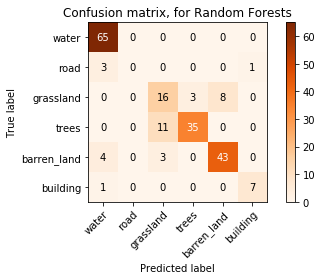

In [56]:
plot_confusion_matrix(model_pred_pd['label'].values, model_pred_pd['prediction'].values, 
                      classes=category_names,
                      title='Confusion matrix, for {}'.format('Random Forests'), 
                      cmap='Oranges')

### 6. Predict using Model from AWS

#### 6.1 Load Random Forest Model Trained on AWS

In [57]:
aws_base_path = './fromAWS'
aws_model_save_path = os.path.join(aws_base_path, 'random_forest.model')

In [58]:
aws_load_forest = RandomForestClassificationModel.load(model_save_path)
'Model Trained on AWS Loaded.'

'Model Trained on AWS Loaded.'

#### 6.2 Evaluation Calculated done over X_test on AWS

In [59]:
pred_labels_saved_path = os.path.join(aws_base_path, 'predictionAndLabels.csv')
predictionAndLabels_from_file = reader.csv(pred_labels_saved_path, sep=',', header=True)
'Predictions and Labels from AWS Loaded.'

'Predictions and Labels from AWS Loaded.'

In [60]:
predictionAndLabels_from_file.shape()

(5076, 2)

In [61]:
metrics = MulticlassMetrics(predictionAndLabels_from_file.rdd)

In [62]:
metrics.precision()

0.762608353033885

In [63]:
metrics.confusionMatrix().toArray()

array([[1.82e+03, 0.00e+00, 4.00e+00, 3.00e+00, 3.00e+00, 1.00e+00],
       [8.60e+01, 0.00e+00, 0.00e+00, 5.00e+00, 2.50e+01, 2.00e+00],
       [1.39e+02, 0.00e+00, 4.07e+02, 9.00e+01, 1.48e+02, 0.00e+00],
       [3.00e+02, 0.00e+00, 6.50e+01, 5.46e+02, 2.60e+01, 1.00e+00],
       [1.03e+02, 0.00e+00, 1.60e+01, 3.70e+01, 1.02e+03, 3.00e+00],
       [1.32e+02, 0.00e+00, 0.00e+00, 1.00e+01, 6.00e+00, 7.90e+01]])

In [64]:
pred_labels_aws_pd = predictionAndLabels_from_file.toPandas()
pred_labels_aws_pd.columns = ['label', 'prediction']
pred_labels_aws_pd.shape

(5076, 2)

In [65]:
pred_labels_aws_pd.head()

,label,prediction
0,4.0,4.0
1,1.0,4.0
2,1.0,1.0
3,5.0,5.0
4,1.0,1.0


#### Overall statistics

In [66]:
# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# Statistics by class
labels = pred_labels_aws_pd.label
for label in sorted(labels):
    print("\n\tClass %d precision = %s" % (label, metrics.precision(label)))
    print("\tClass %d recall = %s" % (label, metrics.recall(label)))
    print("\tClass %d F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))

# Weighted stats
print("\nWeighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Summary Stats
Precision = 0.762608353033885
Recall = 0.762608353033885
F1 Score = 0.762608353033885

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.993979


	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 

	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1


	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 

	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class


	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 

	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1


	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 

	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class

	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1

	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class


	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 


	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 1 recall = 0.9939792008757526
	Class 1 F1 Measure = 0.8248921190097661

	Class 1 precision = 0.7049689440993789
	Class 

	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1


	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 3 recall = 0.5191326530612245
	Class 3 F1 Measure = 0.6379310344827587

	Class 3 precision = 0.8272357723577236
	Class 

	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure 

	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 precision = 0.7901591895803184
	Class 4 recall = 0.582089552238806
	Class 4 F1 Measure = 0.6703499079189688

	Class 4 preci

	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class

	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class

	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1


	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 


	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 5 recall = 0.8654822335025381
	Class 5 F1 Measure = 0.8479071694985495

	Class 5 precision = 0.8310316815597075
	Class 

In [67]:
pred_labels_aws_pd['prediction'].values

array([4., 4., 1., ..., 1., 3., 6.])

#### Confusion Matrix

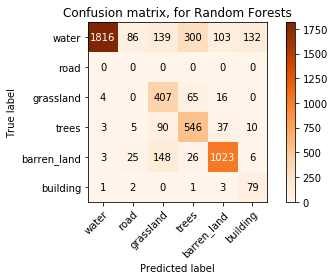

In [68]:
plot_confusion_matrix(pred_labels_aws_pd['label'].values, pred_labels_aws_pd['prediction'].values, 
                      classes=category_names,
                      title='Confusion matrix, for {}'.format('Random Forests'), 
                      cmap='Oranges')

### 7. Use AWS Model to predict on Local Data

#### 7.1 Predict using Model Trained on AWS over Local Test Data

In [69]:
model_pred_aws = aws_load_forest.transform(X_y_test)
model_pred_aws.shape()

(200, 5)

In [70]:
model_pred_aws.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-87.662274284632...|  4.0|[0.0,0.0,0.0,0.22...|[0.0,0.0,0.0,0.07...|       4.0|
|[-103.03198483140...|  4.0|[0.0,0.0,0.0,2.02...|[0.0,0.0,0.0,0.67...|       3.0|
|[-94.520959152479...|  1.0|[0.0,3.0,0.0,0.0,...|[0.0,1.0,0.0,0.0,...|       1.0|
|[-139.40152331099...|  5.0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|       5.0|
|[-47.345336605289...|  1.0|[0.0,3.0,0.0,0.0,...|[0.0,1.0,0.0,0.0,...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [71]:
aws_model_pred_pd = model_pred_aws.select('label', 'prediction').toPandas()
aws_model_pred_pd.shape

(200, 2)

#### 7.2 Evaluation of Model trained on AWS over Custom Local Data

In [72]:
predictionAndLabels_custom = model_pred.select(['prediction', 'label']) \
                        .rdd.map(lambda line: (line[0], line[1]))

In [73]:
metrics = MulticlassMetrics(predictionAndLabels_custom)

In [74]:
metrics.precision()

0.83

In [75]:
metrics.confusionMatrix().toArray()

array([[65.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., 16.,  3.,  8.,  0.],
       [ 0.,  0., 11., 35.,  0.,  0.],
       [ 4.,  0.,  3.,  0., 43.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  7.]])

#### Overall statistics

In [76]:
# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# Statistics by class
labels = model_pred.rdd.map(lambda lp: lp.label).distinct().collect()
for label in sorted(labels):
    print("\n\tClass %d precision = %s" % (label, metrics.precision(label)))
    print("\tClass %d recall = %s" % (label, metrics.recall(label)))
    print("\tClass %d F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))

# Weighted stats
print("\nWeighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Summary Stats
Precision = 0.83
Recall = 0.83
F1 Score = 0.83

	Class 1 precision = 0.8904109589041096
	Class 1 recall = 1.0
	Class 1 F1 Measure = 0.9420289855072463

	Class 2 precision = 0.0
	Class 2 recall = 0.0
	Class 2 F1 Measure = 0.0

	Class 3 precision = 0.5333333333333333
	Class 3 recall = 0.5925925925925926
	Class 3 F1 Measure = 0.5614035087719299

	Class 4 precision = 0.9210526315789473
	Class 4 recall = 0.7608695652173914
	Class 4 F1 Measure = 0.8333333333333333

	Class 5 precision = 0.8431372549019608
	Class 5 recall = 0.86
	Class 5 F1 Measure = 0.8514851485148515

	Class 6 precision = 0.875
	Class 6 recall = 0.875
	Class 6 F1 Measure = 0.875

Weighted recall = 0.8300000000000001
Weighted precision = 0.8190099806324838
Weighted F(1) Score = 0.8214868477694451
Weighted F(0.5) Score = 0.8192347366052124
Weighted false positive rate = 0.04820630089777489


In [77]:
model_pred_pd = model_pred.select('label', 'prediction').toPandas()
model_pred_pd.head()

,label,prediction
0,4.0,4.0
1,4.0,3.0
2,1.0,1.0
3,5.0,5.0
4,1.0,1.0


In [78]:
# model_pred_pd['label'].values
model_pred_pd['prediction'].values

array([4., 3., 1., 5., 1., 4., 1., 5., 1., 1., 1., 3., 3., 1., 4., 3., 5.,
       1., 6., 1., 3., 5., 5., 1., 5., 6., 1., 5., 3., 5., 1., 1., 1., 1.,
       6., 5., 1., 3., 5., 4., 4., 1., 3., 5., 3., 1., 6., 4., 1., 5., 4.,
       5., 4., 3., 4., 4., 4., 3., 1., 1., 5., 1., 3., 1., 1., 4., 5., 5.,
       1., 1., 4., 5., 1., 1., 5., 3., 1., 1., 4., 1., 1., 4., 1., 5., 3.,
       3., 4., 1., 4., 4., 4., 5., 5., 4., 4., 4., 5., 5., 1., 3., 1., 1.,
       6., 1., 5., 3., 6., 5., 1., 5., 1., 5., 5., 1., 5., 5., 1., 5., 5.,
       3., 5., 1., 4., 5., 1., 1., 4., 5., 3., 1., 4., 3., 1., 3., 3., 5.,
       4., 1., 1., 3., 3., 5., 5., 4., 1., 4., 3., 4., 4., 5., 5., 1., 1.,
       5., 1., 5., 4., 5., 4., 1., 1., 5., 1., 1., 3., 1., 1., 4., 1., 5.,
       1., 6., 3., 4., 1., 1., 1., 5., 1., 5., 1., 5., 5., 1., 4., 5., 3.,
       6., 1., 1., 1., 4., 1., 3., 4., 4., 3., 1., 5., 1.])

#### Confusion Matrix

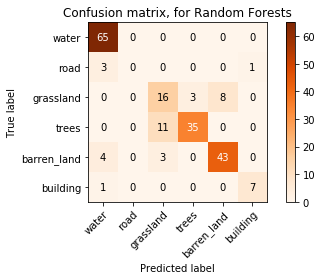

In [79]:
plot_confusion_matrix(model_pred_pd['label'].values, model_pred_pd['prediction'].values, 
                      classes=category_names,
                      title='Confusion matrix, for {}'.format('Random Forests'), 
                      cmap='Oranges')

---

### 8. AWS CLI Export

``` aws emr create-cluster --applications Name=Spark --ebs-root-volume-size 10 --ec2-attributes '{"KeyName":"new_aws","InstanceProfile":"EMR_EC2_DefaultRole","SubnetId":"subnet-10424378","EmrManagedSlaveSecurityGroup":"sg-0780f02d6ffa16917","EmrManagedMasterSecurityGroup":"sg-066631a5bd155d50d"}' --service-role EMR_DefaultRole --release-label emr-5.23.0 --log-uri 's3n://aws-logs-053214817304-us-east-2/elasticmapreduce/' --steps '[{"Args":["spark-submit","--deploy-mode","client","s3://cs696-project-deepsat/project_deepsat_aws.py","-bd","s3://cs696-project/","-od","s3://cs696-project-deepsat/","-p","200","-t","5"],"Type":"CUSTOM_JAR","ActionOnFailure":"CANCEL_AND_WAIT","Jar":"command-runner.jar","Properties":"","Name":"Spark application"}]' --name 'Project' --instance-groups '[{"InstanceCount":1,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":1}]},"InstanceGroupType":"MASTER","InstanceType":"m4.large","Name":"Master Instance Group"},{"InstanceCount":4,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":1}]},"InstanceGroupType":"CORE","InstanceType":"m4.large","Name":"Core Instance Group"}]' --scale-down-behavior TERMINATE_AT_TASK_COMPLETION --region us-east-2 ```

---